# Machine Learning Project Checklist

1. Frame the problem and look at the big picture.

2. Get the data.

3. **Explore the data to gain insights.**

4. Explore many different models and short-list the best ones.

5. Fine-tune your models and combine them into a great solution.

6. Present your solution.

## 3. Explore the data to gain insigths
- Study each attribute and its characteristics
- Visualize the data
- Study the correlations between attributes

In [1]:
import os

In [2]:
REPO_DIR = os.path.join(os.environ['USERPROFILE'], 'repos')
PROJ_DIR = os.path.join(REPO_DIR, 'real_estate_machine_learning')
os.chdir(PROJ_DIR)

In [3]:
DATA_DIR = './data'
RPT_DIR = './reports'
EXT_DIR = os.path.join(DATA_DIR, 'ext')
RAW_DIR = os.path.join(DATA_DIR, 'raw')
INT_DIR = os.path.join(DATA_DIR, 'interim')
PRO_DIR = os.path.join(DATA_DIR, 'processed')
IMG_DIR = os.path.join(DATA_DIR, 'img')

In [4]:
SCRAPE_DATE = '20181101'

In [5]:
import pandas as pd, numpy as np
import re
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from scipy.stats import normaltest
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
import src.preparation as prep
import src.processing as proc
from src.processing import extract_num
import src.visualization as viz
from src.utils import *
%matplotlib inline

## Loading training dataset for Regression
In the *Processing* step I have converted all the features into proper datatypes and created new columns, where the initial feature couldn't be analyzed with the original value representations.  
e.g.: Rooms: 2 full rooms and 1 half room.

In [7]:
train_sale = pd.read_csv(os.path.join(INT_DIR, 'training_sale_{}.csv'.format(SCRAPE_DATE)), encoding='utf8', dtype={'city_district': 'object'}).drop(['property_id', 'id'], axis = 1)
train_rent = pd.read_csv(os.path.join(INT_DIR, 'training_rent_{}.csv'.format(SCRAPE_DATE)), encoding='utf8', dtype={'city_district': 'object'}).drop(['property_id', 'id'], axis = 1)

In [8]:
train_sale.head(3)

address accessibility       ceiling_height        buses  \
0  Budai Bolero II          igen                  NaN  103|133E|33   
1   Csata utca 30.           NaN  3 m-nél alacsonyabb    14|32|105   
2   Csata utca 30.           NaN  3 m-nél alacsonyabb    14|32|105   

   buses_count  furnished                                               desc  \
0          3.0        NaN  | Exkluzív otthon az Ön igényeire szabva! A Bu...   
1          3.0        NaN  | XIII  kerület közkedvelt részén  az Árpád-hí...   
2          3.0        NaN  | XIII  kerület közkedvelt részén  az Árpád-hí...   

  city_district  smoking     floors            ...              \
0            11      NaN         10            ...               
1            13      NaN  földszint            ...               
2            13      NaN          2            ...               

  building_floors                   timestamp elevation room_lt_12_sqm  \
0              10  2018-11-03 08:23:13.955910       102            1.0   
1               5  2018-11-03 08:23:16.124314       106            0.0   
2               5  2018-11-03 08:23:18.277117       106            0.0   

   room_ge_12_sqm room_total  parking_lot_in_huf parking_lot_in_eur  \
0             3.0        4.0           3200000.0                NaN   
1             3.0        3.0           2890000.0                NaN   
2             3.0        3.0           2890000.0                NaN   

   parking_lot_in_huf_monthly parking_lot_in_eur_monthly  
0                         NaN                        NaN  
1                         NaN                        NaN  
2                         NaN                        NaN  

[3 rows x 58 columns]

## Data exploration

In the scraped dataset, if the user didn't fill in the given attribute of listing property e.g. *condition of the real estate, balcony area size* etc. then it will appear as missing datapoint. On other hand if a feature is not applicable for the given listing type e.g. in case of properties for sale *minimum tenancy, smoking allowed, pets allowed* it will appear as missing value as well.

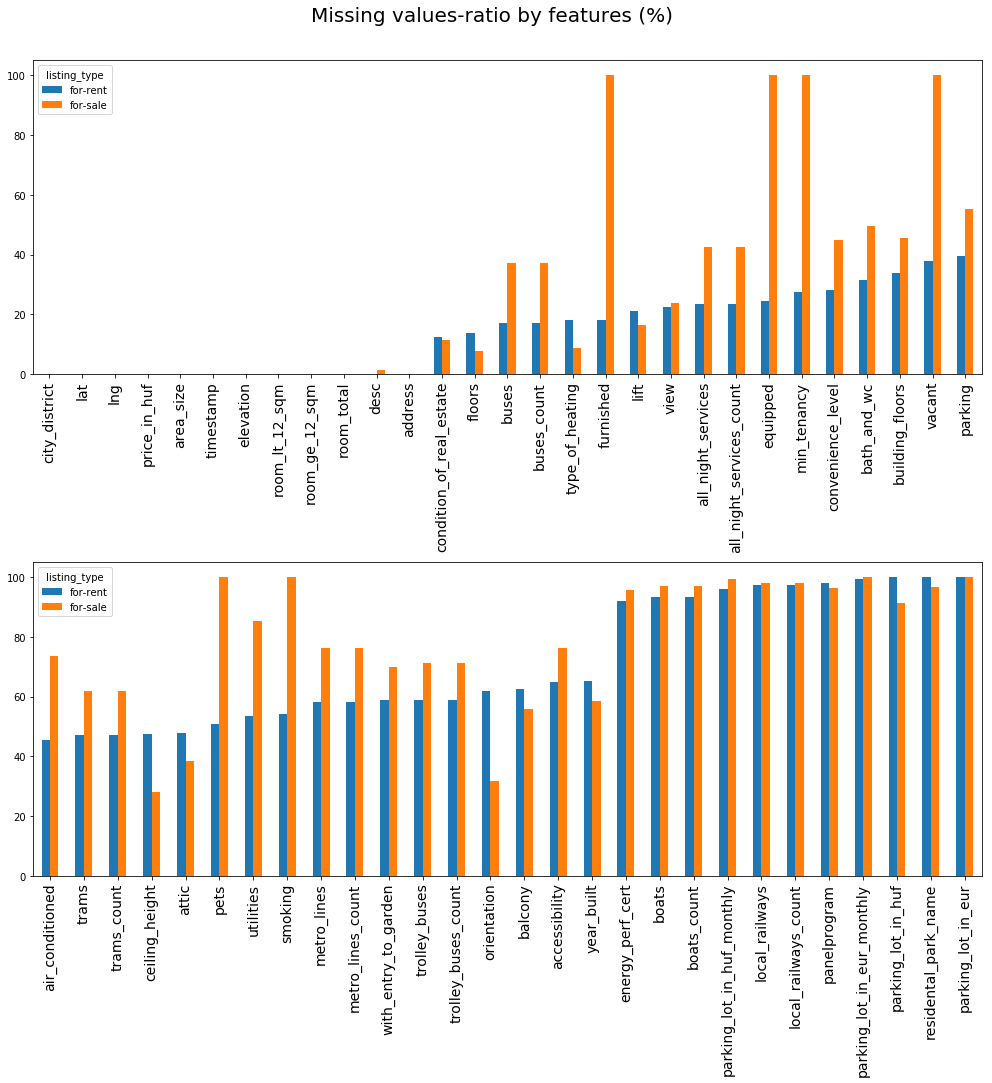

In [9]:
viz.plot_na_ratio(pd.concat([train_sale, train_rent], axis=0), grouping='listing_type', dest_dir=RPT_DIR)
plt.show()

### Missing values
Handling the missing values:
1. No action, using only fully represented variables
2. Impute with mean, median, mode
3. Model the feature leveraging of other variables
4. Using *Natural Language Processing* on property description and combine with the 3rd option  

As a first phase I will use only fully represented features, afterwards I will impute the missing values with predictions of the different models based on NLP, other well-correlated features or the blend of the two.

Fully represented features:
- Price in HUF
- Latitude
- Longitude
- Elevation
- Area size
- Total number of rooms, sum of *rooms equal or greater than 12 m$^2$* and *rooms less than 12 m$^2$*
- District
- Address

The first 6 features measured on ratio scale, others on nominal scale. In machine learning features measured on interval/ratio are preferred.  
**As a first step, my goal is to create an intuitive model, from these features. Desirably with only two explanatory variable to be able to visualize in 3D without reducing dimensions.**

In [10]:
fully_repr_num=['price_in_huf', 'lat', 'lng', 'elevation', 'area_size', 'room_total']

### Distribution of the features

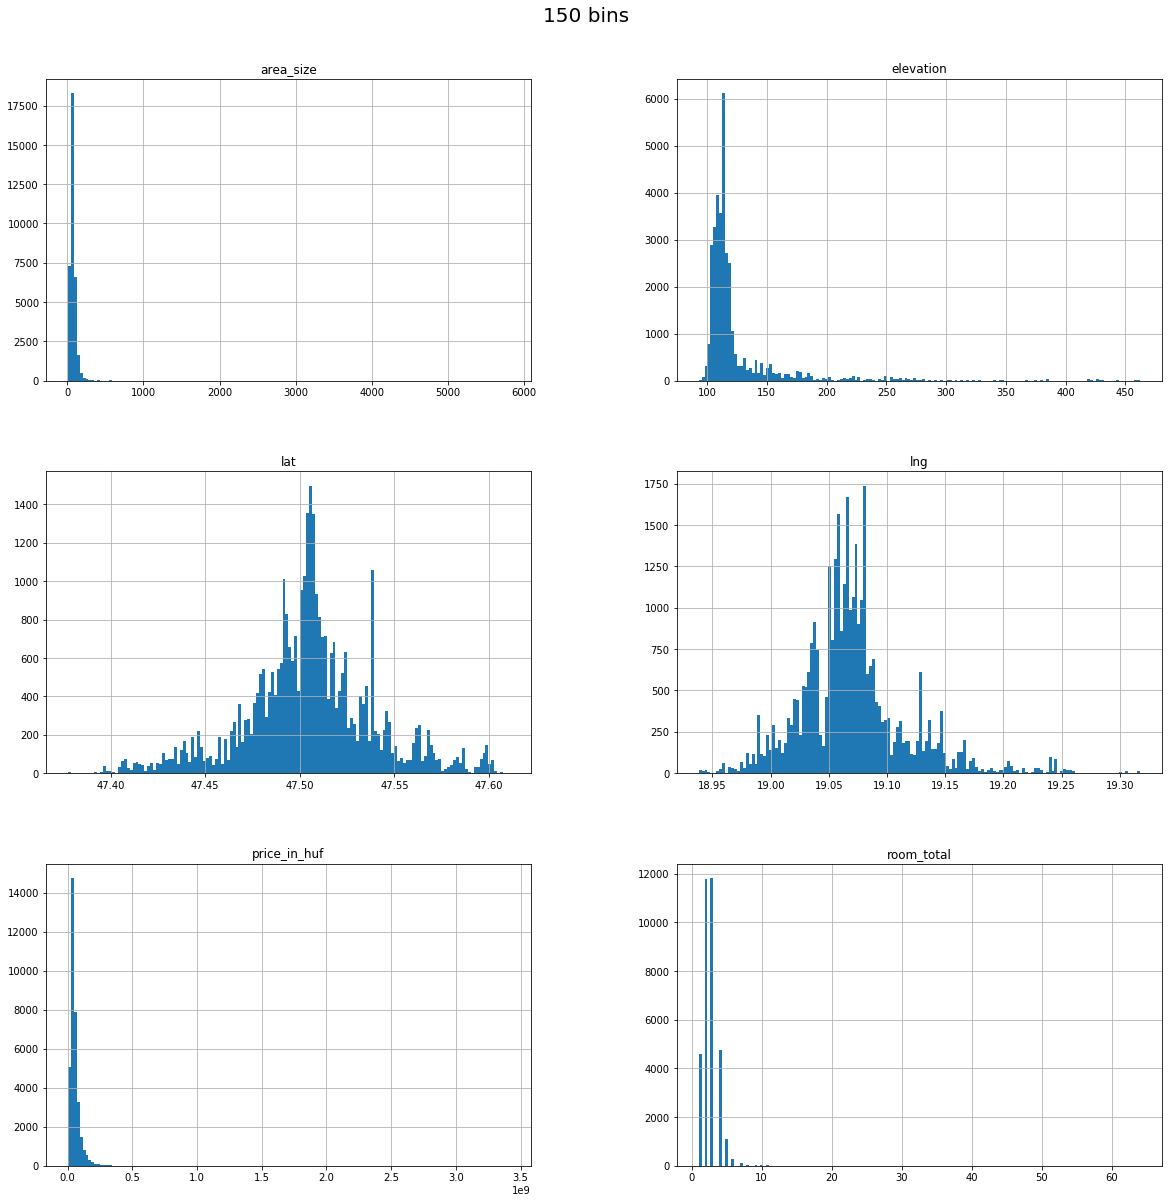

In [11]:
bins=150
train_sale[fully_repr_num].hist(bins=bins, figsize=(20,20))
plt.suptitle('{} bins'.format(bins), fontsize=20, weight=15, y=0.93)
plt.savefig('{0}/{1}_bins_{2}{3}'.format(RPT_DIR, 'histograms', bins, '.png'))

In [12]:
train_sale[fully_repr_num].describe()

price_in_huf           lat           lng     elevation     area_size  \
count  3.460500e+04  34605.000000  34605.000000  34605.000000  34605.000000   
mean   5.393875e+07     47.504952     19.070466    124.059529     72.705274   
std    4.727107e+07      0.034070      0.046005     36.189492     54.358514   
min    2.000000e+06     47.377407     18.938150     93.000000      8.000000   
25%    2.890000e+07     47.488250     19.043684    108.000000     49.000000   
50%    4.280000e+07     47.504910     19.066221    113.000000     64.000000   
75%    6.490000e+07     47.522550     19.085848    120.000000     87.000000   
max    3.410000e+09     47.610500     19.317210    462.000000   5800.000000   

         room_total  
count  34605.000000  
mean       2.677908  
std        1.448156  
min        1.000000  
25%        2.000000  
50%        3.000000  
75%        3.000000  
max       64.000000

Latitude and Longitude have a distribution similar to Gaussian bell curve, which is really useful property.  
Price in huf, area size and total number of rooms have similar distribution to Log-normal, although they are inflated with outliers, e.g. minimum size of property is 8 m$^2$ and maximum size of property is 5800 m$^2$.  
These outliers can be an user input mistake or if even they are valid inputs they are not representing well an average real estate in Budapest, therefore the data needs to be normalized by removing outliers.

### Relationship between variables
- Linear relationship (correlation matrices)
- Look for non-linear relationship (scatter-plot)

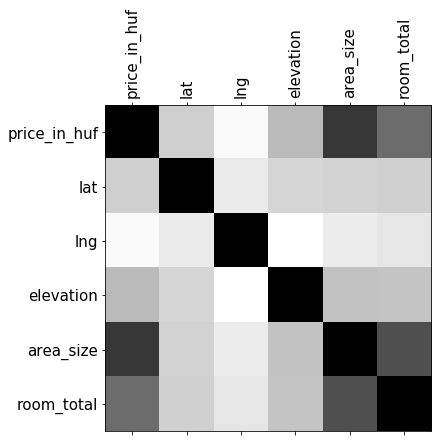

In [13]:
fig=plt.figure(figsize=(6,6))
ax=fig.gca()
ax.matshow(train_sale[fully_repr_num].corr(), cmap='Greys')
ax.xaxis.set_ticklabels(ticklabels=['']+train_sale[fully_repr_num].corr().columns.tolist(), rotation=90, fontsize=15)
ax.yaxis.set_ticklabels(ticklabels=['']+train_sale[fully_repr_num].corr().columns.tolist(), fontsize=15)
plt.show()

Some obvious relationships can be found, such as area size is well-correlated with the price and with total number of rooms.

In [14]:
corr=train_sale[fully_repr_num].corr()
corr.style.background_gradient()

All in all it is redundant to include both area size and total number of rooms into the model as explanatory varibles, since area size is better correlated with the price and more continous than number of rooms. Other than that there are no significant linear relationship between the features above.

In [15]:
fully_repr_num.pop(fully_repr_num.index('room_total'))

'room_total'

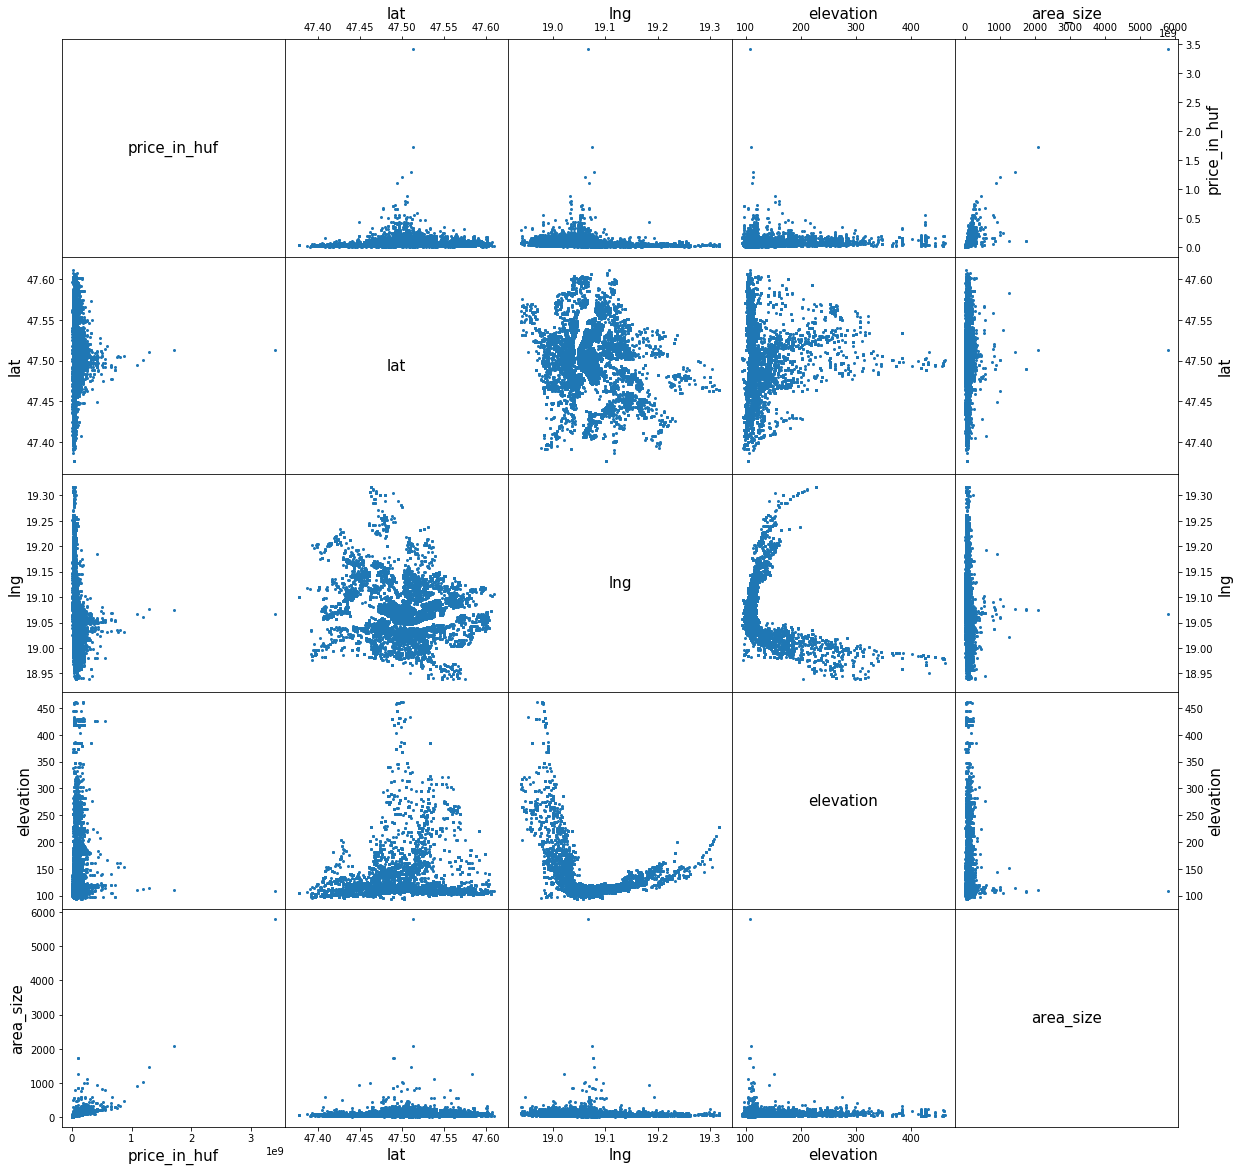

In [16]:
viz.plot_scatter_matrix(train_sale[fully_repr_num])
plt.show()

### Outlier detection
The method I will use is z-score or standardization, which is a simple approach to filter out the outliers.
- Standardization:
    - Subtracting mean (centered)
    - Dividing by standard deviation (scaled)  
    
However this methow works well only with quasi normally distributed features.

### Data transformation
- Log-Normal Distribution

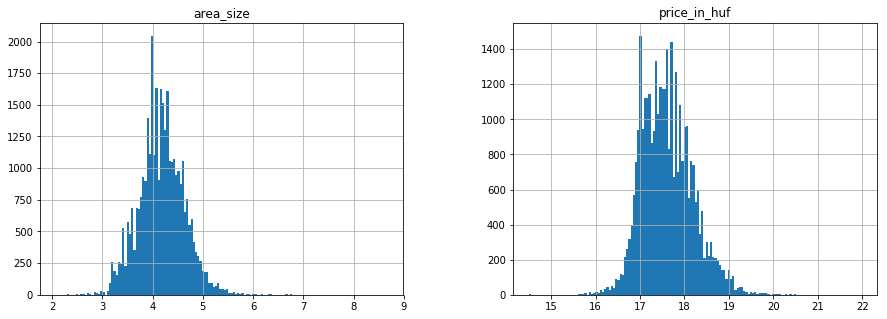

In [17]:
train_sale[['price_in_huf', 'area_size']].apply(np.log).hist(bins=bins, figsize=(15,5))
plt.show()

### Adding transformed features

In [18]:
train_sale.loc[:,'log_price_in_huf']=train_sale.price_in_huf.apply(np.log)
train_sale.loc[:,'log_area_size']=train_sale.area_size.apply(np.log)

In [19]:
quasi_normal_dist = ['lat', 'lng', 'log_price_in_huf', 'log_area_size']

In [20]:
scaler=StandardScaler()

In [21]:
st_train_sale_values=scaler.fit_transform(train_sale[quasi_normal_dist])

In [22]:
st_train_sale=pd.DataFrame(st_train_sale_values, columns=quasi_normal_dist)

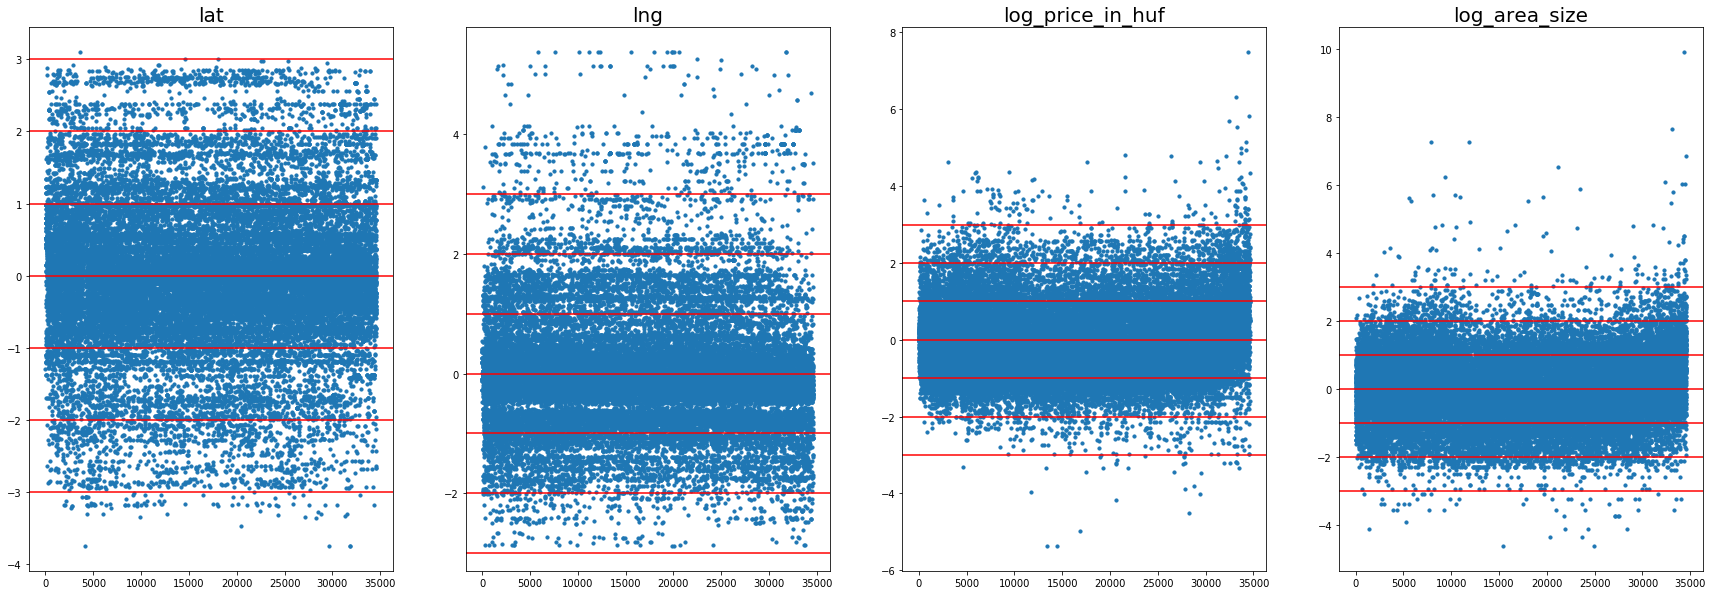

In [23]:
viz.plot_outliers(st_train_sale, n_std=3)
plt.show()

Number of sigmas (standard deviations) from the mean should be decided:

### Set sigma

In [24]:
ratios = proc.calc_outlier_ratio(st_train_sale, columns = ['lat', 'lng', 'log_price_in_huf', 'log_area_size'])

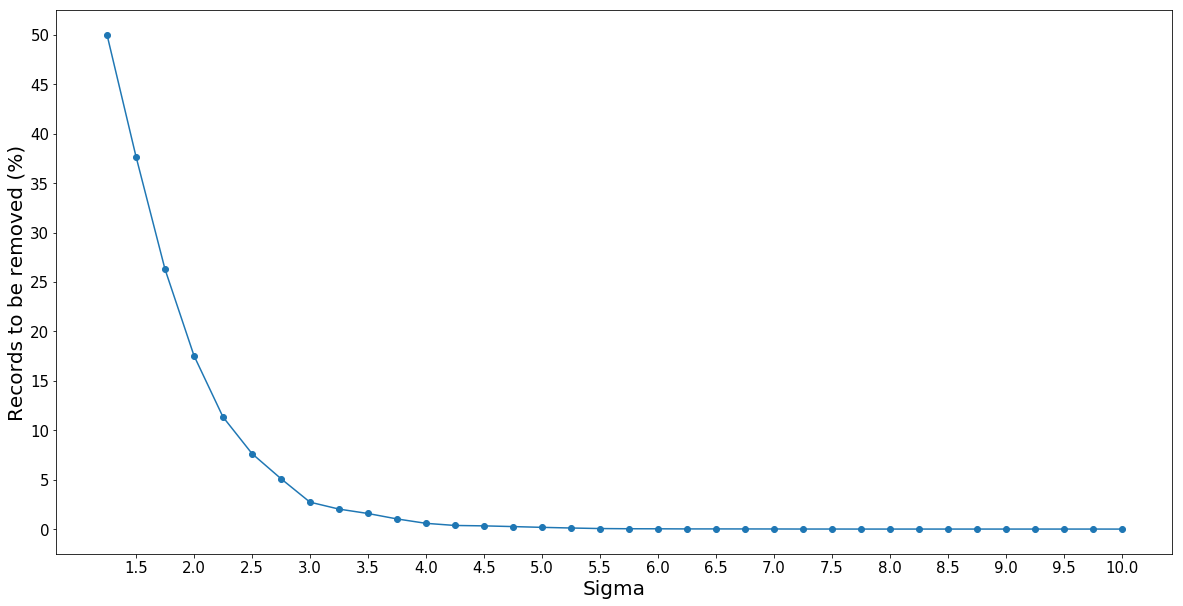

In [25]:
fig=plt.figure(figsize=(20,10))
plt.plot(ratios[:,0], ratios[:,1], marker='o')
plt.xticks(np.arange(10, 1, -0.5), fontsize=15)
plt.yticks(np.arange(50, -1, -5), fontsize=15)
plt.xlabel('Sigma', fontsize=20)
plt.ylabel('Records to be removed (%)', fontsize=20)
plt.show()

### Sigma input

In [26]:
sigma=2.5

In [27]:
outlier_mask = proc.create_outlier_mask(st_train_sale, columns = ['lat', 'lng', 'log_price_in_huf', 'log_area_size'], sigma_threshold = 2.5)

In [28]:
print('Removed records: {0:.3}%'.format(ratios[ratios[:,0] == 2.5, 1][0]))

Removed records: 7.64%


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


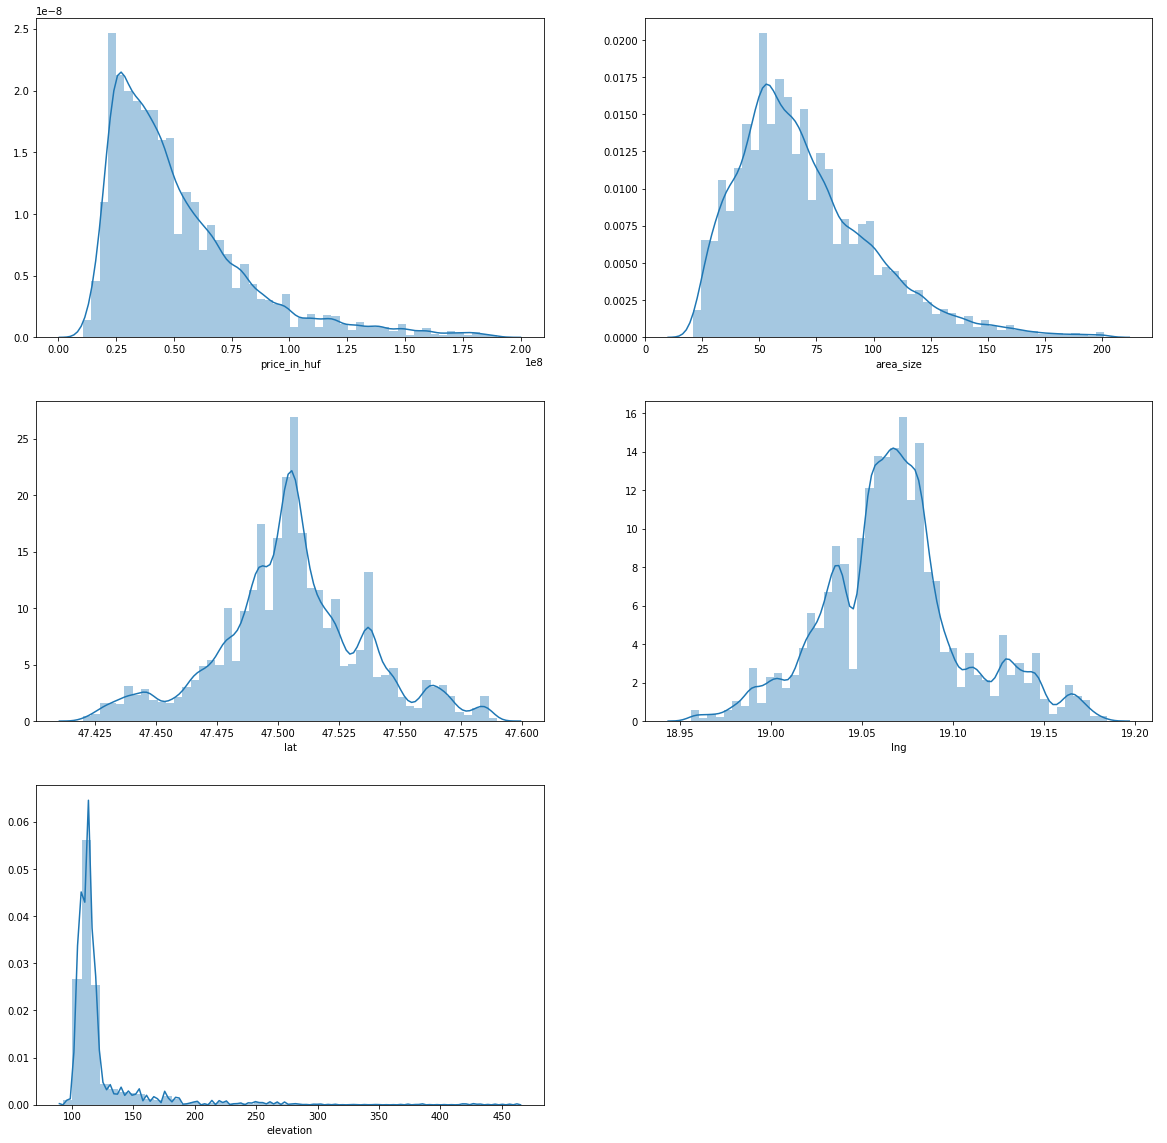

In [29]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(20, 20)
sns.distplot(a=train_sale.loc[outlier_mask, 'price_in_huf'], ax = axs[0,0])
sns.distplot(a=train_sale.loc[outlier_mask, 'area_size'], ax = axs[0,1])
sns.distplot(a=train_sale.loc[outlier_mask, 'lat'], ax = axs[1,0])
sns.distplot(a=train_sale.loc[outlier_mask, 'lng'], ax = axs[1,1])
sns.distplot(a=train_sale.loc[outlier_mask, 'elevation'], ax = axs[2,0])
axs[2,1].axis('off')
plt.show()

After removing outliers, estimated distribution of the features look better, although histogram of *Latitude* and *Longitude* have some strange spikes, which is worth investigating.

### Longitude, Latitude

Calculation of the right picture ratio to plot the map of Budapest, capital city of Hungary.

In [30]:
min_gps=train_sale.loc[outlier_mask, ['lng', 'lat']].min()
max_gps=train_sale.loc[outlier_mask, ['lng', 'lat']].max()
pic_ratio=(max_gps['lat']-min_gps['lat'])/(max_gps['lng']-min_gps['lng'])
print(pic_ratio)

0.7405126861435021


In [31]:
opt_fig_size=viz.calc_fig_size(pic_ratio, 2.5)

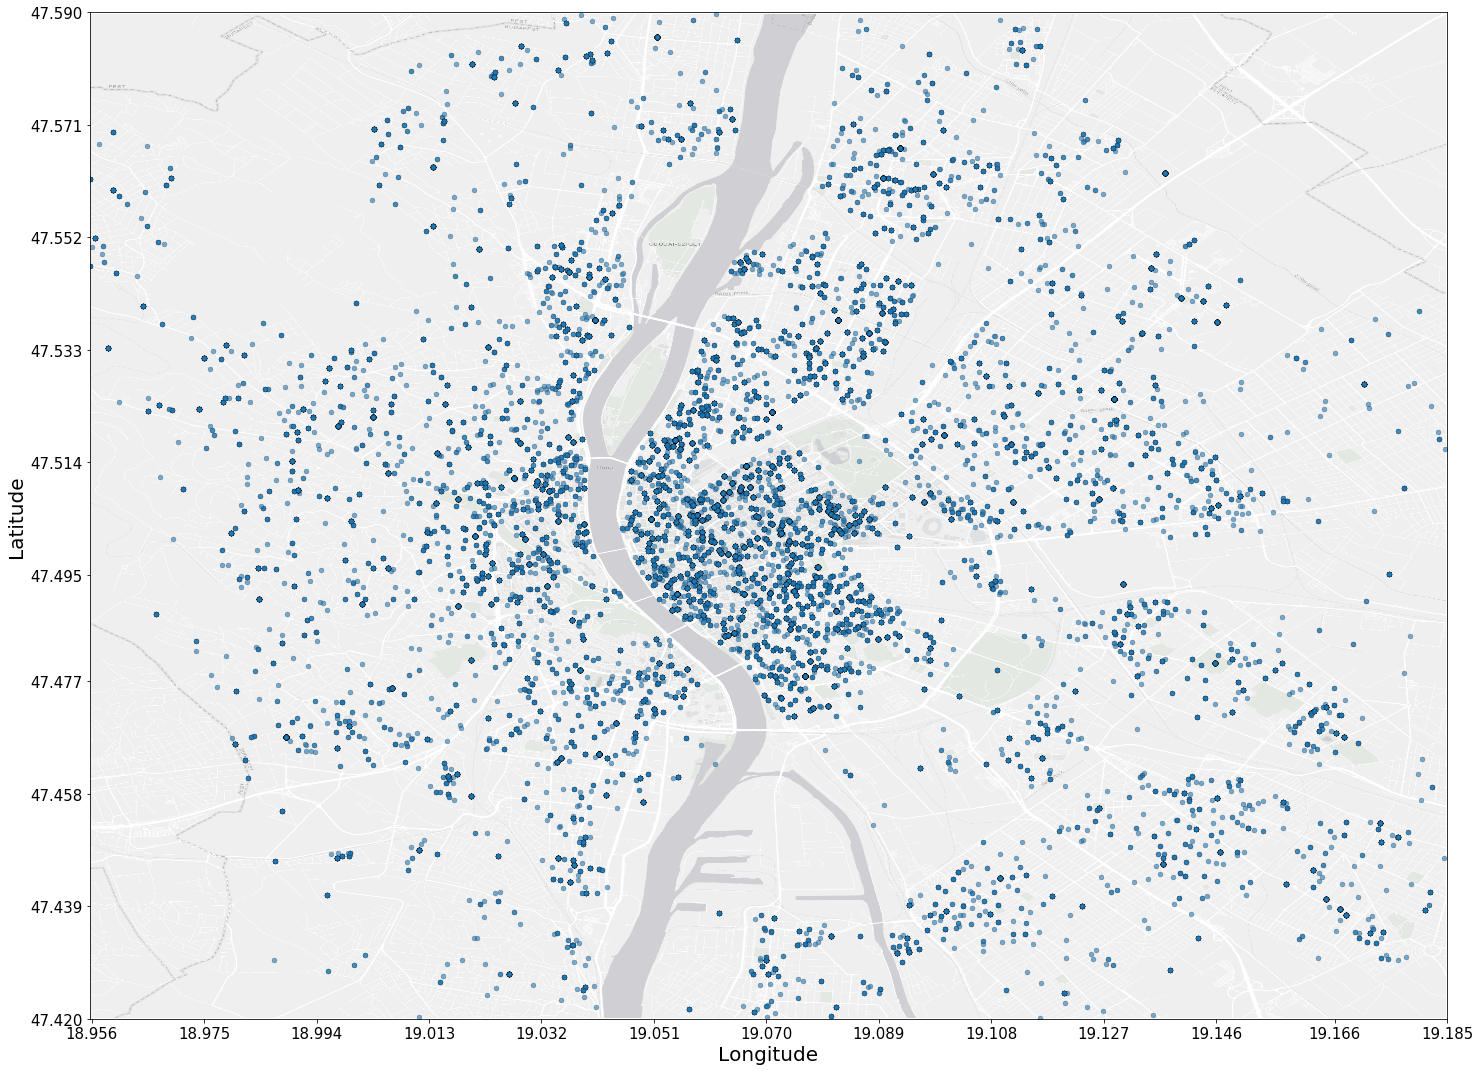

In [32]:
viz.plot_scatter_map(x=train_sale.loc[outlier_mask, 'lng'], y=train_sale.loc[outlier_mask, 'lat'], xlabel='Longitude', ylabel='Latitude', figsize=opt_fig_size, alpha = 0.6, dpi=160)
plt.show()

Decreasing the alpha to see the density of properties for sale in the map:

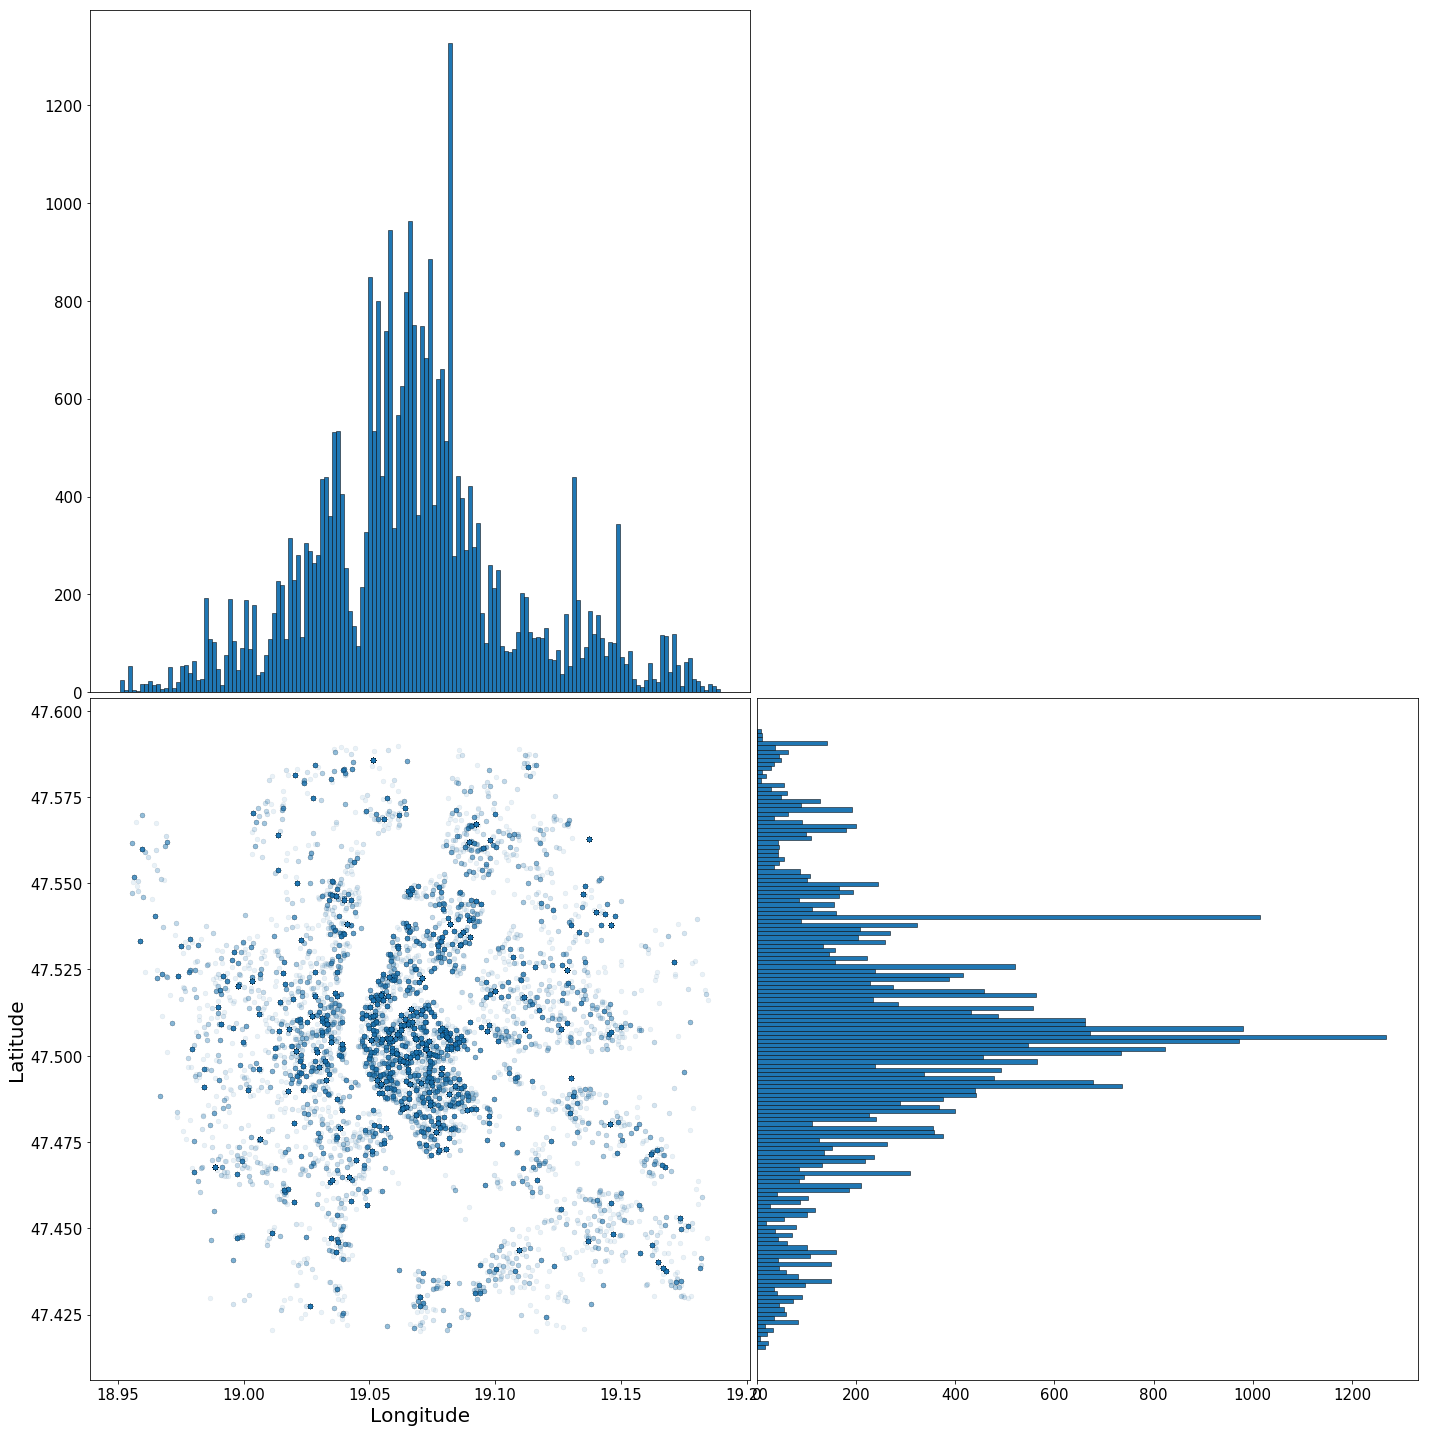

In [33]:
viz.plot_sca_hist(train_sale.loc[outlier_mask, ['lng', 'lat']], 'lng', 'lat', bins, 'Longitude', 'Latitude', alpha=0.1)
plt.show()

Check the data distributed by districts:  
[Source of the picture](http://erdekesvilagunk.blog.hu/2013/11/17/budapest_tortenet)

In [34]:
rnd_colors = load_pkl(os.path.join(RAW_DIR, 'colors_23_2'))

In [35]:
if not isinstance(locals().get('rnd_colors', None), np.ndarray):
    rnd_colors=np.random.choice(list(mpl.cm.colors.cnames.keys()), size=23, replace=False)

In [36]:
im_districts = mpimg.imread(os.path.join(IMG_DIR, 'districts.gif'))

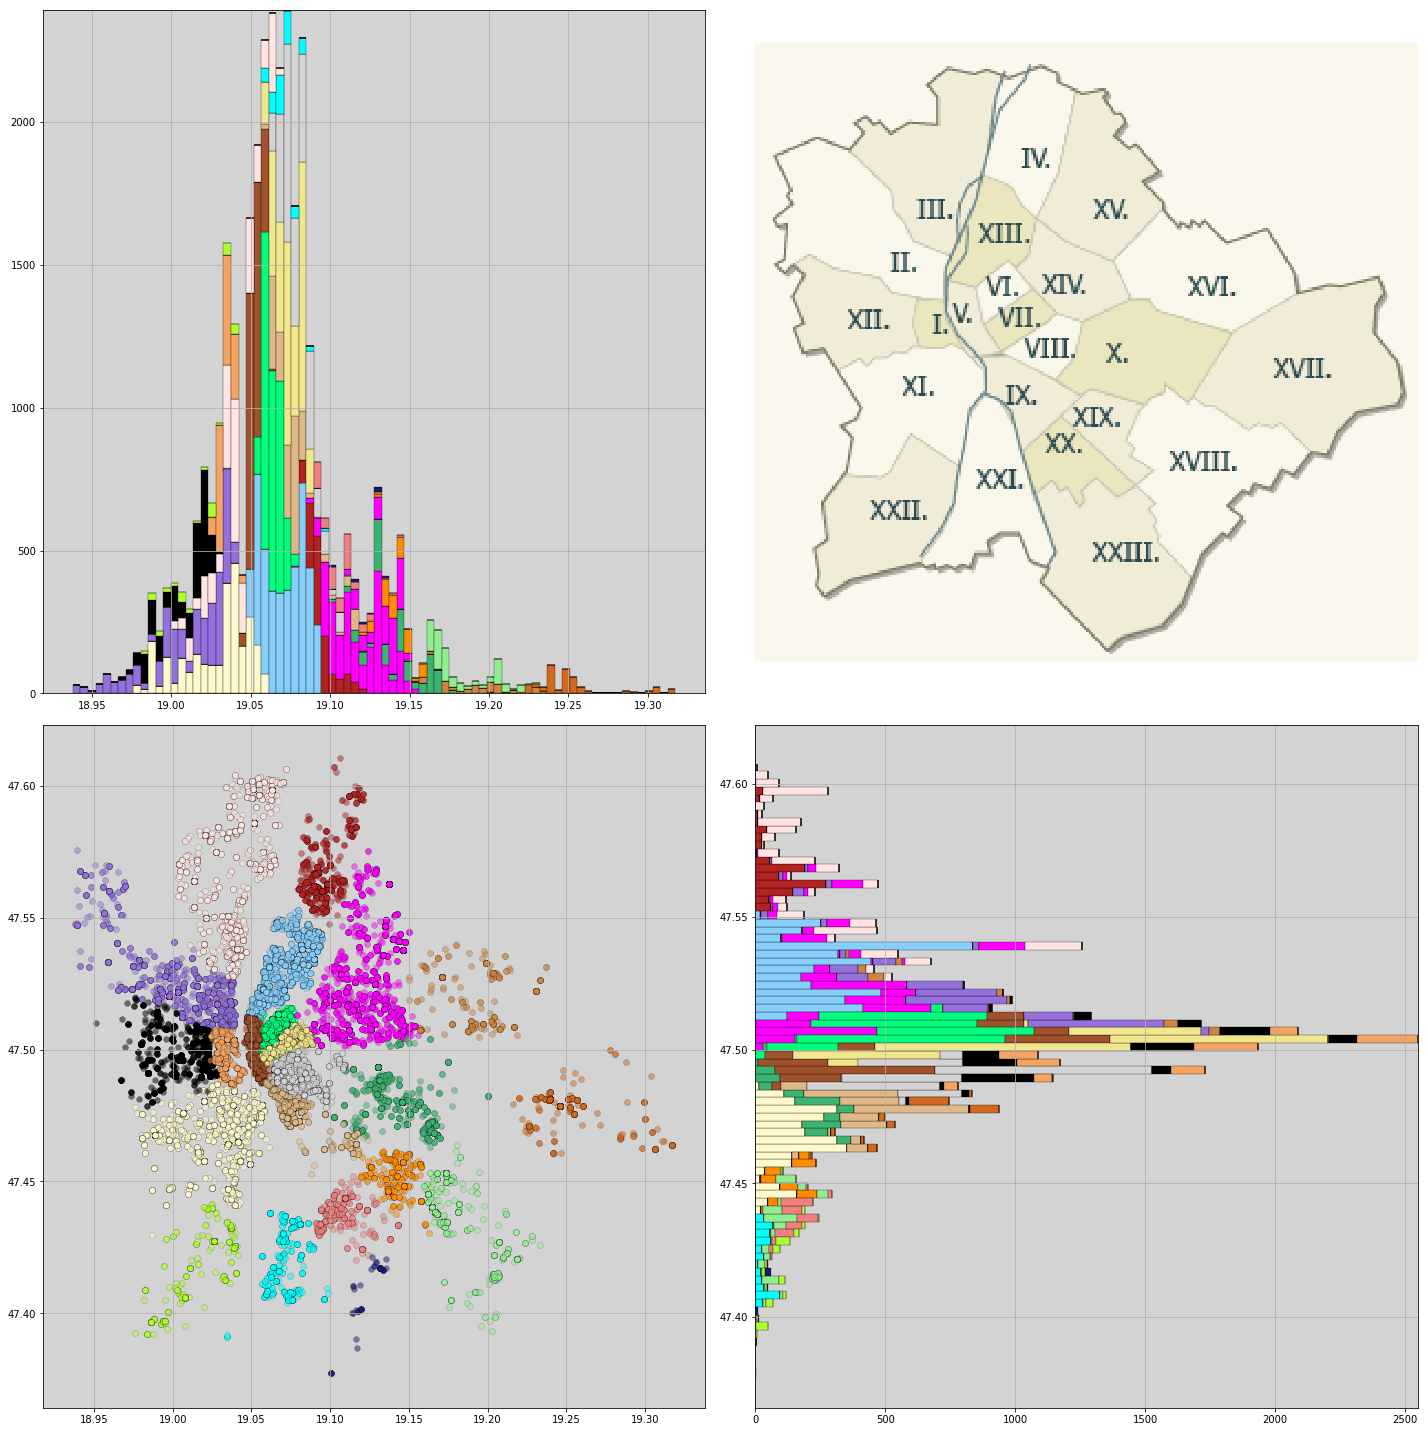

In [37]:
fig, axs = viz.plot_sca_stackedhist(train_sale, 'lng', 'lat', 'city_district', rnd_colors)
axs[0,1].imshow(im_districts)
plt.show()

In [38]:
gps_count = train_sale[['lat', 'lng', 'address']].groupby(['lat', 'lng']).count().reset_index().rename(columns = {'address': 'gps_count'})

In [39]:
train_sale = train_sale.merge(how='left', right=gps_count, on=['lat', 'lng'])

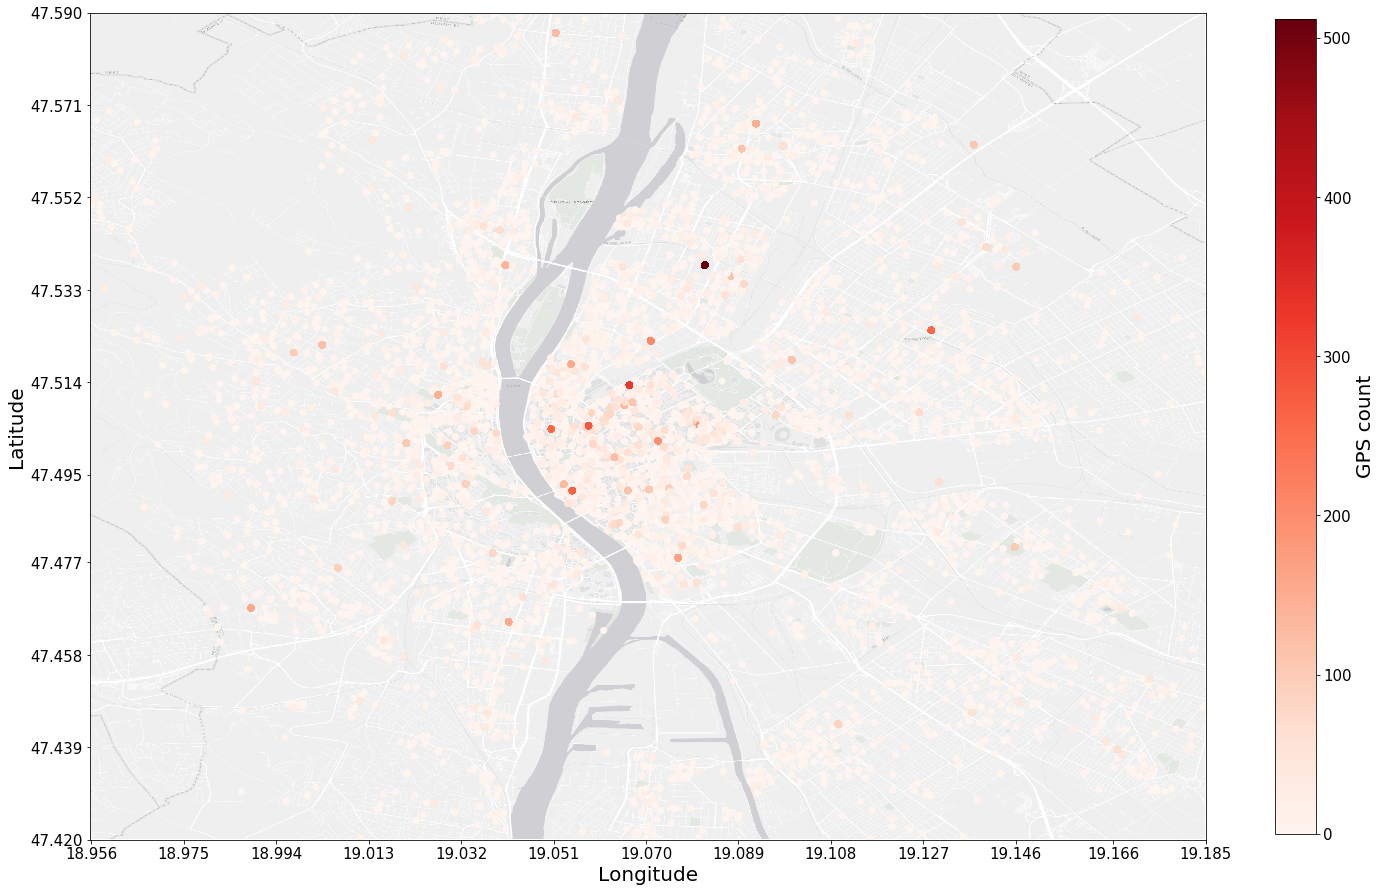

In [40]:
viz.plot_scatter_map(x=train_sale.loc[outlier_mask, 'lng'],
                 y=train_sale.loc[outlier_mask, 'lat'],
                 c=train_sale.loc[outlier_mask, 'gps_count'],
                 colormap='Reds', c_bar_shrink=0.81,
                 xlabel='Longitude', ylabel='Latitude', clabel='GPS count',
                 linewidth=0, s=50, alpha=1,
                 figsize=opt_fig_size, dpi=160)
plt.show()

The darker the dot in the map the more properties are listed for sale on the exact spot. It indicates either people want to sell off their apartment under the same address or there are some errors occured during data gathering.

Top 10 number of addresses pointing to the same GPS coordinates:

In [41]:
train_sale.loc[outlier_mask, ['gps_count', 'address']].sort_values('gps_count', ascending = False).drop_duplicates().head(10)

gps_count                    address
12052        512                 Angyalföld
18516        512                Nerium Park
30143        329           Külső-Terézváros
17138        282           Belső-Terézváros
33845        268                   Belváros
16740        259                 Lipótváros
15531        258                  Alsórákos
4152         206  Angyalföld – Lőportárdűlő
276          206     Young City 3 by Cordia
286          206           Kassák Residence

It turns out that these addresses don't contain the street name and the street number, but only the name of the district, sub-district or the residental park name.  
The issue with the gps coordinates is that if the user has not specified the exact address only the district then gps coordinates point to the center of the district, sub-district. They cover too broad area, consequently longitude and latitude pairs are not accurate enough.  
**Solution**: remove these records.  

Four homogeneity levels have been identified:
1. Fully specified address (contains street number, street name) e.g. Király utca 13.
2. Residental park is defined e.g. Greenside
3. Street name is given e.g. Mester utca
4. Sub-district name is provided e.g. Aquincum  

Threshold should be decided, which homogeneity levels to include in the dataset and which to exclude.

Fully specified address  
To find all the fully specified addresses in the dataset, I downloaded the official list of the available public domain names in Hungary, such as: street, road, square, lane etc. and with the help of regular expressions I can create a pattern to filter out these addresses.

In [42]:
public_domains=prep.load_public_domain_names(os.path.join(EXT_DIR, 'public_domains_2015_09_07.txt'))

In [43]:
public_domains[:5]

['akna', 'akna-alsó', 'akna-felső', 'alagút', 'alsórakpart']

In [44]:
street_num_ptrn='|'.join(['.*{}.*\d'.format(d) for d in public_domains])
street_num_mask=train_sale.address.apply(lambda a: bool(re.match(string=str(a), pattern=street_num_ptrn)))
print('Number of records with fully specified address: {0:,}'.format(street_num_mask.sum()))

Number of records with fully specified address: 2,084


In [45]:
train_sale.loc[street_num_mask, ['address']].tail()

address
34542              Dohány utca 9.
34558          Hock János utca 3.
34570             Fenyőfa utca 1.
34571  Kőrösi Csoma Sándor út 40.
34574         Törökbálinti út 24.

Residental park  
Newly built or apartments are being built can be found under residental park definition, these properties pointing to the same GPS spot correctly, therefore should be included in the dataset.

In [46]:
residental_park_mask=train_sale.loc[:,'residental_park_name'].notnull()
print('Number of records with residental parks: {0:,}'.format(residental_park_mask.sum()))

Number of records with residental parks: 1,096


In [47]:
train_sale.loc[residental_park_mask, ['address']].head()

address
0       Budai Bolero II
7   Dagály Park 1. ütem
8   Dagály Park 1. ütem
9   Dagály Park 1. ütem
10  Duna Terasz Premium

Street name  
If the user provide only the street name, then GPS coordinates will be pointing to middle of the street, which is not the most accurate category, but it is still representing relatively well the residental area.  
To filter out street names wihtout street number I used regex.

In [48]:
pub_domain_ptrn='|'.join(['.* {}$'.format(d) for d in public_domains])
public_domains_mask=train_sale.address.apply(lambda a: bool(re.match(string=str(a), pattern=pub_domain_ptrn)))
print('Number of records with street name only: {0:,}'.format(public_domains_mask.sum()))

Number of records with street name only: 21,308


In [49]:
train_sale.loc[public_domains_mask, ['address']].tail()

address
34595           Bimbó út
34596     Felhévízi utca
34597   Podmaniczky utca
34598  Hercegprímás utca
34600     Vörösmarty tér

In [50]:
address_mask = street_num_mask|residental_park_mask|public_domains_mask

In [51]:
print('Number of records after removing addresses with sub-disticts {0:,}'.format(train_sale.loc[address_mask, 'address'].count()))

Number of records after removing addresses with sub-disticts 24,392


In [52]:
masks = address_mask & outlier_mask

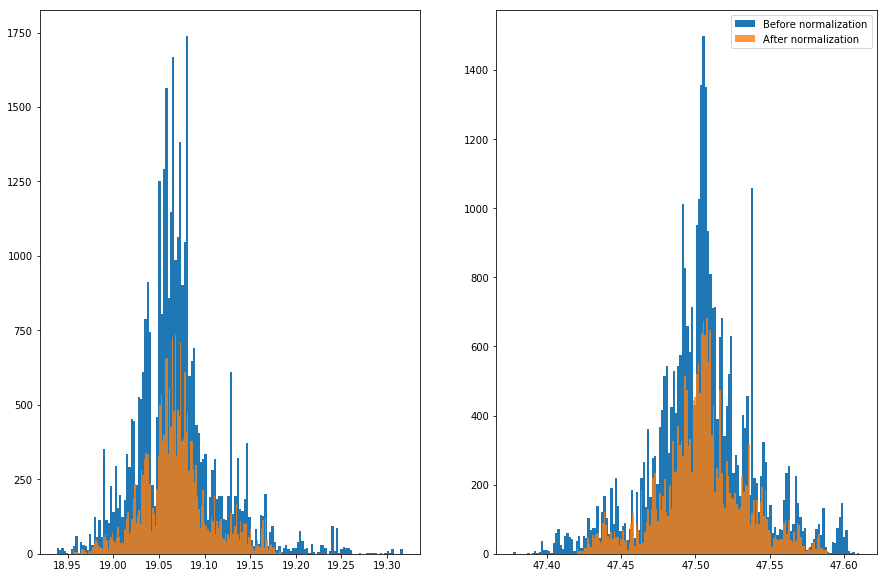

In [53]:
bins=150
fig, axs = plt.subplots(1,2)
fig.set_size_inches(30,20)
train_sale.loc[:, 'lng'].hist(bins=bins, ax=axs[0])
train_sale.loc[masks, 'lng'].hist(figsize=(15,10), bins=bins, ax=axs[0], alpha=0.8, grid = False)
train_sale.loc[:, 'lat'].hist(bins=bins, ax=axs[1])
train_sale.loc[masks, 'lat'].hist(figsize=(15,10), bins=bins, ax=axs[1], alpha=0.8, grid = False)
axs[1].legend(['Before normalization', 'After normalization'])
plt.show()

After data normalization, I managed to eliminate big spikes in the histogram.

In [54]:
cl_train_sale = train_sale[masks]

In [55]:
print('Number of records after data normalization {0:,}'.format(cl_train_sale.loc[:, 'address'].count()))

Number of records after data normalization 22,660


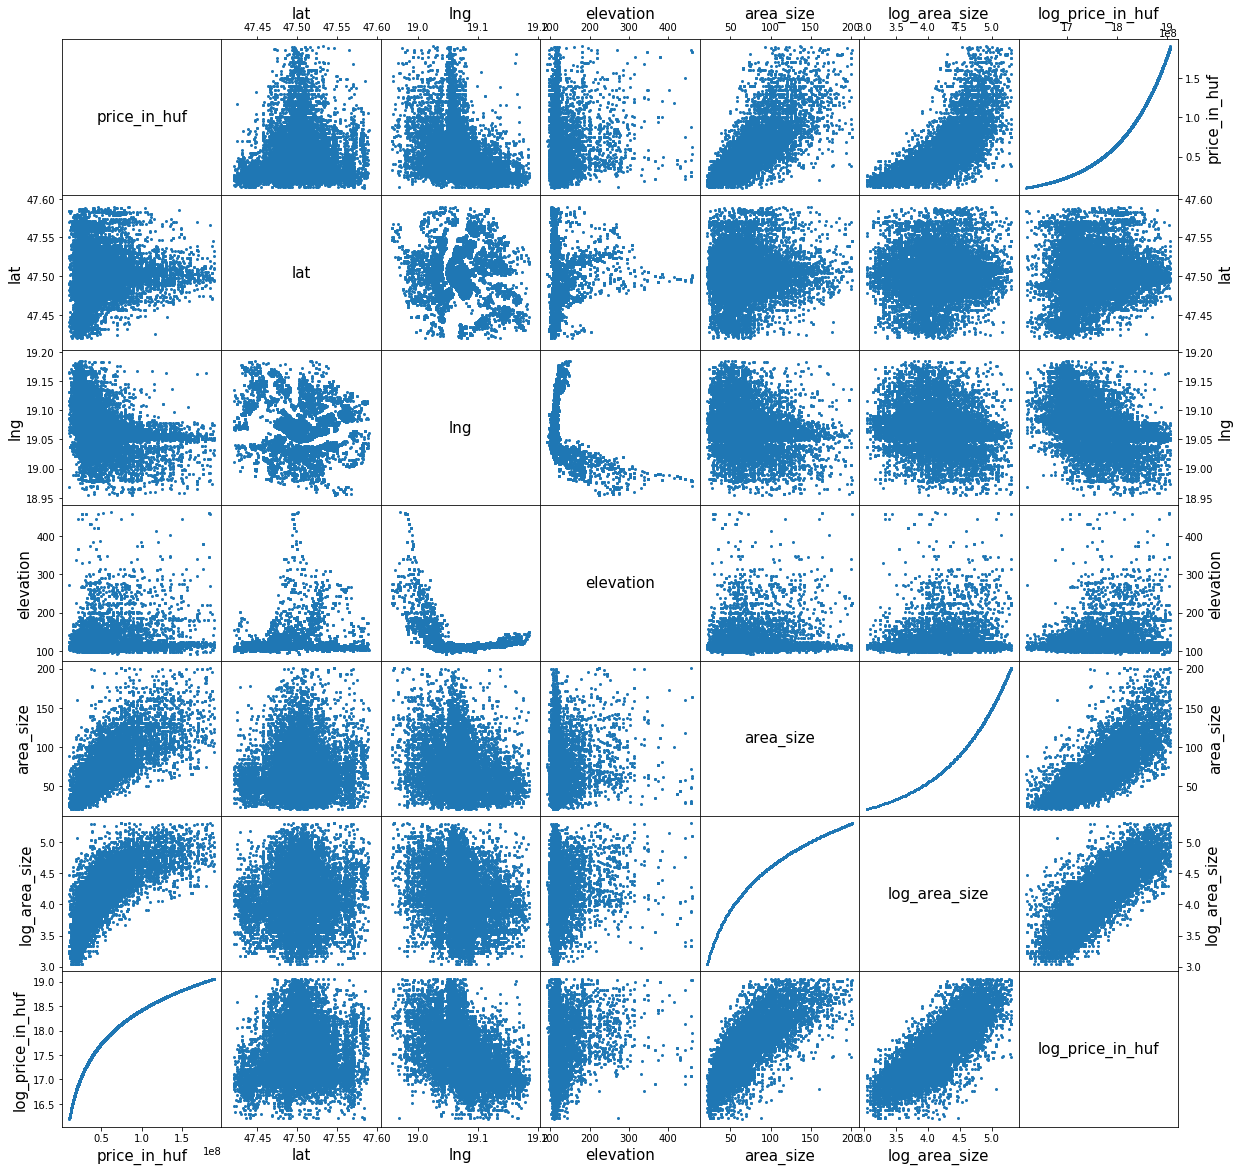

In [56]:
viz.plot_scatter_matrix(cl_train_sale.loc[:, fully_repr_num + ['log_area_size', 'log_price_in_huf']])
plt.show()

The machine learning model wants to predict the fair offer price or a given apartment:
- Price as predicted variable
Main features should be included into the model:
- Area size as explanatory variable
- Latitude as explanatory variable
- Longitude as explanatory variable  

However, there are more than 2 explanatory variables, which will not make it possible to visualize the model's decision function in 3D without dimension reduction. 

Relationship between price - area_size

In [57]:
lr_log = LinearRegression(fit_intercept=True)
lr = LinearRegression(fit_intercept=True)

In [58]:
lr_log.fit(X=cl_train_sale[['log_area_size']], y=cl_train_sale['log_price_in_huf'])
lr.fit(X=cl_train_sale[['area_size']], y=cl_train_sale['price_in_huf'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [59]:
print('Area size - price elasticity is: {0:.2}%'.format(lr_log.coef_[0]))

Area size - price elasticity is: 0.99%


In [60]:
folds_n=100
cv_log=cross_val_score(estimator=lr_log, cv=folds_n, X=cl_train_sale[['log_area_size']], y=cl_train_sale['log_price_in_huf'])
cv=cross_val_score(estimator=lr, cv=folds_n, X=cl_train_sale[['area_size']], y=cl_train_sale['price_in_huf'])
print("Linear model R2 is: {0:%}".format(np.mean(cv)))
print("Log-log model R2 is: {0:%}".format(np.mean(cv_log)))

Linear model R2 is: 56.247838%
Log-log model R2 is: 59.403949%


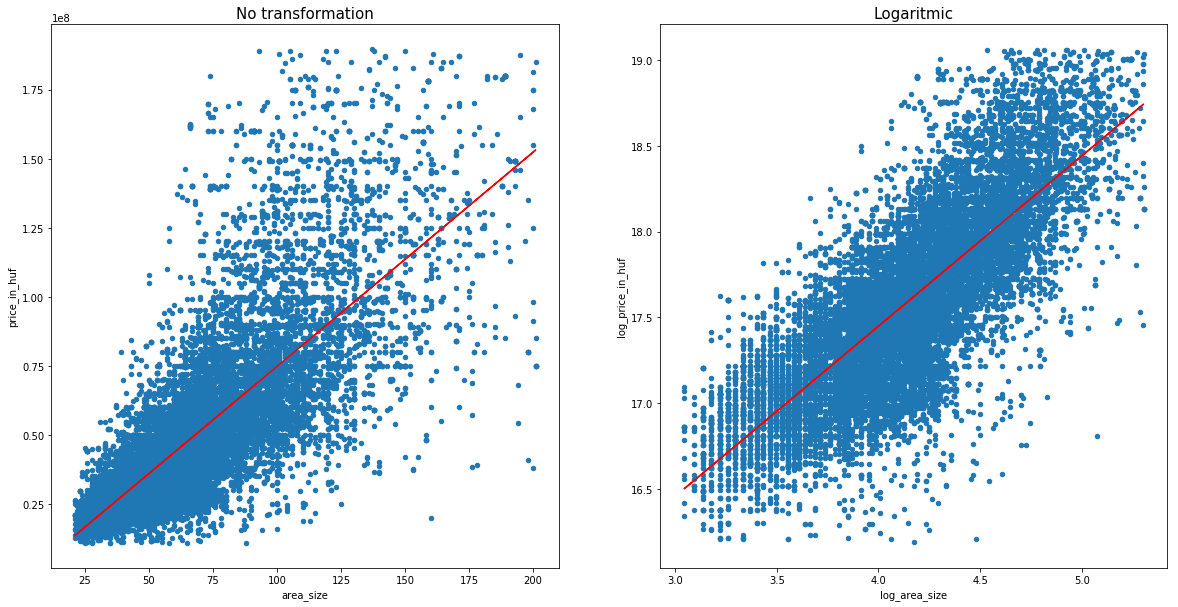

In [61]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20,10)
cl_train_sale.plot.scatter(x='area_size', y='price_in_huf', ax=axs[0])
cl_train_sale.plot.scatter(x='log_area_size', y='log_price_in_huf', ax=axs[1])
axs[0].plot(cl_train_sale.area_size, lr.predict(X=cl_train_sale[['area_size']]), c='r')
axs[1].plot(cl_train_sale.log_area_size, lr_log.predict(X=cl_train_sale[['log_area_size']]), c='r')
axs[0].set_title('No transformation', fontsize=15)
axs[1].set_title('Logaritmic', fontsize=15)
plt.show()

All in all the relationship between price and area size is pretty linear, therefore it makes sense to add a new feature by dividing Price with area size. It also decreases the model dimensions.

### Creating new dependant variable
- Price per squaremeter:
    $\frac{price}{area}$<br><br>

In [62]:
cl_train_sale['price_per_sqm'] =cl_train_sale.price_in_huf/cl_train_sale.area_size

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Test dataset
Do all the data cleaning steps on the testing set as well.
1. Removing outliers
2. Get rid of the not proper addresses
3. Adding new features

In [63]:
test_sale = pd.read_csv(os.path.join(INT_DIR, 'testing_sale_{}.csv'.format(SCRAPE_DATE)), encoding='utf8', dtype={'city_district': 'object'}).drop(['property_id', 'id'], axis = 1)
test_rent = pd.read_csv(os.path.join(INT_DIR, 'testing_rent_{}.csv'.format(SCRAPE_DATE)), encoding='utf8', dtype={'city_district': 'object'}).drop(['property_id', 'id'], axis = 1)

In [64]:
test_sale.loc[:,'log_price_in_huf']=test_sale.price_in_huf.apply(np.log)
test_sale.loc[:,'log_area_size']=test_sale.area_size.apply(np.log)

In [65]:
st_test_sale_values=scaler.fit_transform(test_sale[quasi_normal_dist])
st_test_sale=pd.DataFrame(st_test_sale_values, columns=quasi_normal_dist)

In [66]:
outlier_mask = proc.create_outlier_mask(st_test_sale, columns = ['lat', 'lng', 'log_price_in_huf', 'log_area_size'], sigma_threshold = 2.5)

In [67]:
street_num_ptrn='|'.join(['.*{}.*\d'.format(d) for d in public_domains])
street_num_mask=test_sale.address.apply(lambda a: bool(re.match(string=str(a), pattern=street_num_ptrn)))
print('Number of records with fully specified address: {0:,}'.format(street_num_mask.sum()))

Number of records with fully specified address: 530


In [68]:
residental_park_mask=test_sale.loc[:,'residental_park_name'].notnull()
print('Number of records with residental parks: {0:,}'.format(residental_park_mask.sum()))

Number of records with residental parks: 260


In [69]:
pub_domain_ptrn='|'.join(['.* {}$'.format(d) for d in public_domains])
public_domains_mask=test_sale.address.apply(lambda a: bool(re.match(string=str(a), pattern=pub_domain_ptrn)))
print('Number of records with street name only: {0:,}'.format(public_domains_mask.sum()))

Number of records with street name only: 5,544


In [70]:
address_mask = street_num_mask|residental_park_mask|public_domains_mask

In [71]:
print('Number of records after removing addresses with sub-disticts {0:,}'.format(test_sale.loc[address_mask, 'address'].count()))

Number of records after removing addresses with sub-disticts 6,321


In [72]:
masks = address_mask & outlier_mask

In [73]:
cl_test_sale = test_sale[masks]

In [74]:
cl_test_sale['price_per_sqm'] =cl_test_sale.price_in_huf/cl_test_sale.area_size

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Eyeballing the heat map
The cleaned dataset looks like this before modelling. On these datapoints I will fit a model to predict the fair offer price of the real estate in Budapest.

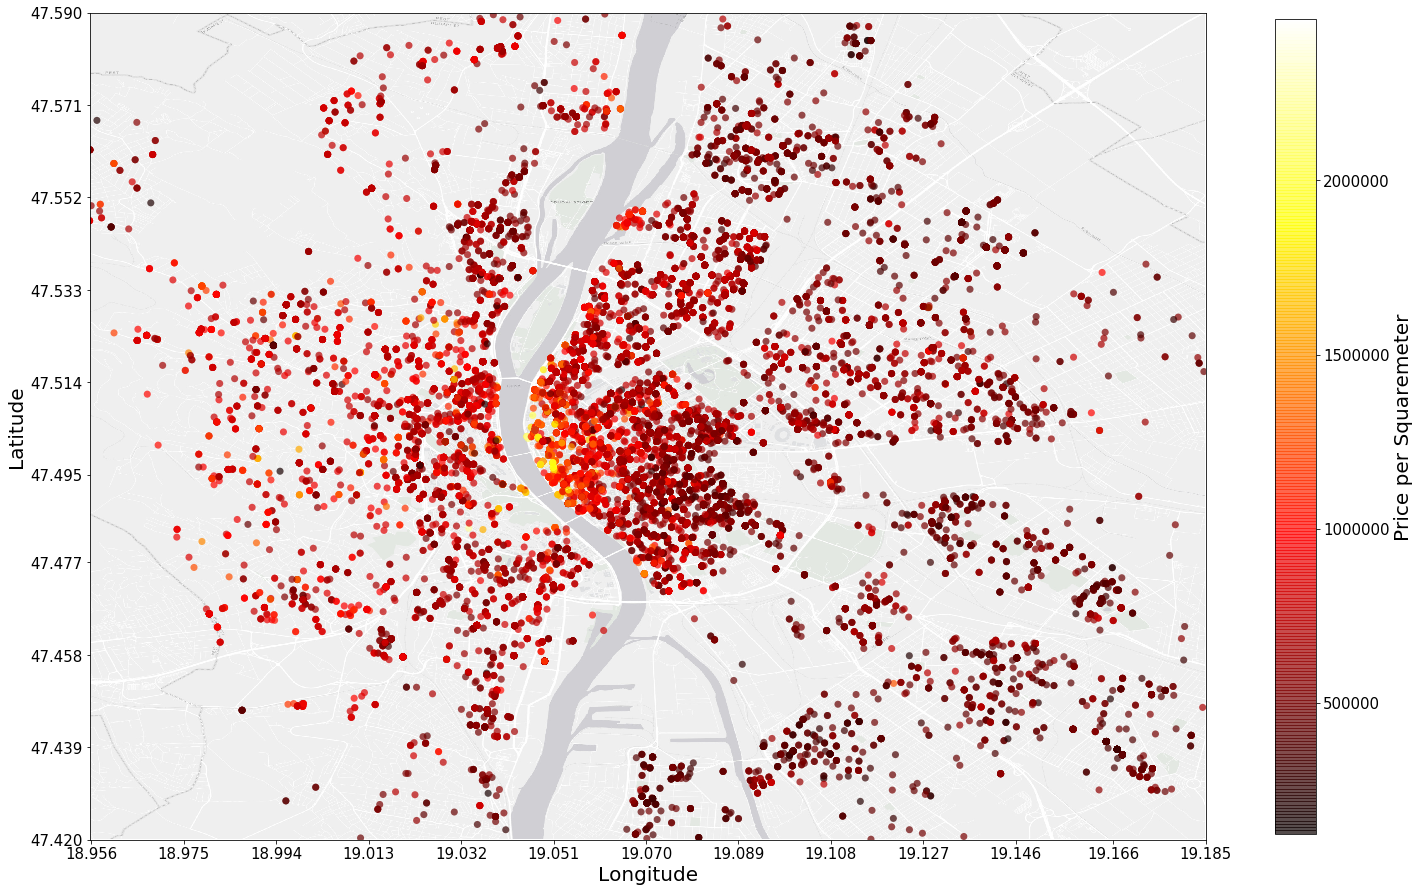

In [75]:
viz.plot_scatter_map(x=cl_train_sale.loc[:, 'lng'],
                 y=cl_train_sale.loc[:, 'lat'],
                 c=cl_train_sale.loc[:, 'price_per_sqm'],
                 colormap='hot', c_bar_shrink=0.81,
                 xlabel='Longitude', ylabel='Latitude', clabel='Price per Squaremeter',
                 linewidth=0, s=50, alpha=0.7,
                 figsize=opt_fig_size, dpi=160)
plt.show()

Saving the processed and cleaned dataset:

In [78]:
fns = ['training_sale_{}.csv', 'testing_sale_{}.csv']
fns_date = [n.format(SCRAPE_DATE) for n in fns]
dfs =[cl_train_sale, cl_test_sale]

In [79]:
for fn, df in zip(fns_date, dfs):
    df.to_csv(os.path.join(PRO_DIR, fn), encoding='utf8', index=False)